# Machine Learning for Stock Trading:  PCA and Clustering
**Hugh Donnelly, CFA**<br>
*AlphaWave Data*

**April 2021**

## Introduction

In developing a Pairs Trading strategy, finding valid, eligible pairs that exhibit unconditional mean-reverting behavior is of critical importance. We walk through an example implementation of finding eligible pairs and then perform a backtest on a selected pair. We show how popular algorithms from Machine Learning can help us navigate a very high-dimensional search space to find tradable pairs.

Jupyter Notebooks are available on [Google Colab](https://colab.research.google.com/drive/1r2ZyFqDn8X9w2qOereU5T7xwr94acesA?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Data%20Machine%20Learning%20for%20Stock%20Trading%20PCA%20and%20Clustering%20example.ipynb).

For this project, we use several Python-based scientific computing technologies listed below.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

import requests
from bs4 import BeautifulSoup
import time

import pymc3 as pm

import theano as th
import seaborn as sns


## 1. Define the Stock Universe

We start by specifying that we will constrain our search for pairs to a large and liquid single stock universe. To achieve this, we create a function that scrapes the tickers of the S&P 500 and then cleans the tickers by replacing those containing a `.` with a `-` so we can easily use them in [AlphaWave Data's APIs](https://www.alphawavedata.com/).

In [2]:
# Scrape the S&P 500 tickers from Wikipedia

def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']
    return ticker_options

In [3]:
# Run the ticker scrape function
# Let's convert the get_tickers() output to a list and 
# replace tickers that have '.' with '-' so we can use AlphaWave Data APIs

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))
# stock_tickers

505


## 2. Retrieve ESG and Market Cap Data
Let's use some fundamental and environmental, social and governance (ESG) classification data to search for pairs. When we look for pairs (or model anything in quantitative finance), it is generally good to have an "economic prior", as this helps mitigate overfitting. We will start with the following priors:

- Stocks that share loadings to common factors (defined below) in the past should be related in the future.
- Stocks of similar market caps should be related in the future.
- ESG Risk Ratings assess the degree to which a company's enterprise business value is at risk driven by environmental, social and governance issues. Within the [Alphawave Data ESG Risk Ratings for Stocks API](https://rapidapi.com/alphawave/api/esg-risk-ratings-for-stocks), the `controversy score` identifies companies involved in incidents and events that may negatively impact stakeholders, the environment or the company's operations. Controversies are graded on a scale from A to F with F denoting the most serious controversies with the largest potential impact.

We can use the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) to pull a company's Market Cap from the [Key Statistics](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_dff4b882-4be4-4169-a700-04275c92bdce) endpoint and the [AlphaWave Data ESG Risk Ratings for Stocks API](https://rapidapi.com/alphawave/api/esg-risk-ratings-for-stocks) to retrieve the `controversy score`.

To call these APIs with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the APIs with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [4]:
# Fetch controversy score and market cap data

key_stats_url = "https://stock-analysis.p.rapidapi.com/api/v1/resources/key-stats"

key_stats_headers = {
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

esg_url = "https://esg-risk-ratings-for-stocks.p.rapidapi.com/api/v1/resources/esg"

esg_headers = {
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

esg_data = []

for ticker in stock_tickers:
    querystring = {"ticker":ticker}
    
    try:
        # Market Cap
        key_stats_response = requests.request("GET", key_stats_url, headers=key_stats_headers, params=querystring)
        key_stats_df = pd.DataFrame.from_dict(key_stats_response.json())
        key_stats_df = key_stats_df.transpose()
        
        market_cap_str = key_stats_df.loc[r'Market cap (intra-day) '][0]

        market_cap_lst = market_cap_str.split('.')
        if market_cap_str[len(market_cap_str)-1] == 'T':
            market_cap_length = len(market_cap_lst[1])-1
            market_cap_lst[1] = market_cap_lst[1].replace('T',(9-market_cap_length)*'0')
            market_cap_int = int(''.join(market_cap_lst))
        if market_cap_str[len(market_cap_str)-1] == 'B':
            market_cap_length = len(market_cap_lst[1])-1
            market_cap_lst[1] = market_cap_lst[1].replace('B',(6-market_cap_length)*'0')
            market_cap_int = int(''.join(market_cap_lst))
        
        # Controversy Score
        esg_score_response = requests.request("GET", esg_url, headers=esg_headers, params=querystring)
        esg_score_df = pd.DataFrame.from_dict(esg_score_response.json())
        esg_score_df = esg_score_df.transpose()
        controversy_datapoint = esg_score_df['Controversy Score']
        
        # Create Dataframe
        df = pd.DataFrame({'Controversy Score': controversy_datapoint,
                           'Market Cap': market_cap_int},
                          index=[ticker])

        esg_data.append(df)
    except:
        pass

result_esg_df = pd.concat(esg_data, ignore_index=False)
result_esg_df

,Controversy Score,Market Cap
MMM,C,117560000
ABT,C,195290000
ABBV,C,203860000
ACN,B,181340000
ATVI,B,76260000
...,...,...
XLNX,A,31580000
XYL,B,21270000
YUM,C,35660000
ZBH,B,32970000


In this analysis, we replace the `controversy score` ratings with decimal scores ranging from zero to one.

In [5]:
# replace the categorical data with numerical scores per the docs
result_esg_df['Controversy Score'] = result_esg_df['Controversy Score'].astype(str)
controversy_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
result_esg_df = result_esg_df.replace({'Controversy Score': controversy_dict})

result_esg_df['Controversy Score'] = result_esg_df['Controversy Score'].astype(float)

In [6]:
# Let's take a look at the shape and top of the dataframe

print (result_esg_df.shape)
result_esg_df.head()

(447, 2)


,Controversy Score,Market Cap
MMM,0.7,117560000
ABT,0.7,195290000
ABBV,0.7,203860000
ACN,0.3,181340000
ATVI,0.3,76260000


We then remove zero values to create our desired stock ticker list.

In [7]:
# Remove Controversy Scores and Market Cap with 0 as value

result_esg_df = result_esg_df.loc[~((result_esg_df['Controversy Score'] == 0) | (result_esg_df['Market Cap'] == 0))]

# print (result_esg_df.shape)
result_esg_df.head()

,Controversy Score,Market Cap
MMM,0.7,117560000
ABT,0.7,195290000
ABBV,0.7,203860000
ACN,0.3,181340000
ATVI,0.3,76260000


In [8]:
result_esg_df.describe()

,Controversy Score,Market Cap
count,405.000000,4.050000e+02
mean,0.377284,8.491556e+07
std,0.233097,2.053946e+08
min,0.100000,5.510000e+06
25%,0.300000,1.817000e+07
50%,0.300000,3.292000e+07
75%,0.700000,7.207000e+07
max,1.000000,2.240000e+09


In [9]:
# Use the index of the dataframe that removes 0 values as the clean stock ticker list
# for the prices dataframe so that the symbols match between both dataframes

clean_stock_tickers = list(result_esg_df.index)
len(clean_stock_tickers)

405

## 3. Retrieve Stock Price Data

We can use the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints) to pull in the two year historical prices.  From this, we are going to calculate the daily returns for each stock selected.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [11]:
# Fetch 2 year daily return data

url = "https://stock-prices2.p.rapidapi.com/api/v1/resources/stock-prices/2y"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

stock_frames = []

for ticker in clean_stock_tickers:
    querystring = {"ticker":ticker}
    stock_daily_price_response = requests.request("GET", url, headers=headers, params=querystring)

    # Create Stock Prices DataFrame
    stock_daily_price_df = pd.DataFrame.from_dict(stock_daily_price_response.json())
    stock_daily_price_df = stock_daily_price_df.transpose()
    stock_daily_price_df = stock_daily_price_df.rename(columns={'Close':ticker})
    stock_daily_price_df = stock_daily_price_df[{ticker}]
    stock_frames.append(stock_daily_price_df)

combined_stock_price_df = pd.concat(stock_frames, axis=1, sort=True)

pct_change_combined_stock_df = combined_stock_price_df.pct_change()

returns = pct_change_combined_stock_df.dropna()
returns

,MMM,ABT,ACN,ATVI,ADBE,AAP,AES,AFL,A,APD,...,WY,WHR,WMB,WLTW,WYNN,XEL,XYL,YUM,ZBH,ZTS
2019-04-30,-0.003680,0.016481,0.008057,-0.003926,0.010869,-0.002698,0.002166,0.013274,0.015130,0.010905,...,0.012849,0.001877,0.001414,0.015535,-0.029038,0.018936,-0.005011,0.005684,0.019283,0.005728
2019-05-01,-0.018152,-0.010307,-0.007445,0.007260,-0.020398,-0.014971,-0.012850,-0.003176,-0.013121,-0.017688,...,-0.005970,0.006771,-0.012354,-0.048660,0.011700,-0.010619,-0.001319,-0.023470,-0.015752,-0.000491
2019-05-02,-0.007094,0.000508,-0.010590,0.020387,-0.013093,0.018006,0.008876,0.000597,0.009423,0.027208,...,-0.006757,0.018245,-0.018585,0.017848,-0.003969,0.000358,-0.045023,-0.001962,0.016416,0.013361
2019-05-03,0.002544,-0.001142,-0.013434,-0.048436,0.021241,-0.021046,-0.007038,0.004776,0.013939,0.009295,...,0.012094,0.001054,0.004734,0.007115,0.012366,0.011803,0.034574,0.009632,0.008928,0.005817
2019-05-06,-0.011770,0.004829,-0.004068,0.021421,-0.006723,-0.007840,-0.007088,0.000594,0.000757,-0.017130,...,-0.006721,-0.017408,-0.007611,-0.006341,-0.040717,-0.001237,-0.026856,-0.003018,0.009975,-0.004048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-22,0.000100,0.007341,-0.001926,0.005581,-0.009857,0.002151,-0.002466,-0.010467,0.005230,-0.013478,...,-0.009686,-0.006434,-0.013582,-0.010987,-0.012779,-0.002804,-0.003654,0.003150,0.004133,-0.006347
2021-04-23,0.006471,-0.001538,0.005445,-0.007257,0.016854,-0.002746,-0.000706,0.008122,0.015982,0.019527,...,0.009781,0.024658,0.015921,-0.001115,-0.001849,-0.000562,0.012835,-0.000849,0.001353,0.008695
2021-04-26,-0.012710,-0.005920,-0.007610,0.013115,-0.000271,-0.013066,-0.003180,0.000000,0.004829,-0.000413,...,0.016754,-0.011802,0.015248,-0.006827,0.006847,-0.006753,-0.000362,-0.017329,-0.010697,-0.004339
2021-04-27,-0.025948,-0.007179,0.002521,-0.028014,0.003141,0.000710,-0.014534,0.002998,-0.006262,-0.001344,...,0.013903,0.013722,-0.001252,0.021401,0.022000,-0.008499,0.008330,0.006311,0.003585,-0.000294


In [16]:
print (returns.shape)
returns.head()

(504, 405)


,MMM,ABT,ACN,ATVI,ADBE,AAP,AES,AFL,A,APD,...,WY,WHR,WMB,WLTW,WYNN,XEL,XYL,YUM,ZBH,ZTS
2019-04-30,-0.003680,0.016481,0.008057,-0.003926,0.010869,-0.002698,0.002166,0.013274,0.015130,0.010905,...,0.012849,0.001877,0.001414,0.015535,-0.029038,0.018936,-0.005011,0.005684,0.019283,0.005728
2019-05-01,-0.018152,-0.010307,-0.007445,0.007260,-0.020398,-0.014971,-0.012850,-0.003176,-0.013121,-0.017688,...,-0.005970,0.006771,-0.012354,-0.048660,0.011700,-0.010619,-0.001319,-0.023470,-0.015752,-0.000491
2019-05-02,-0.007094,0.000508,-0.010590,0.020387,-0.013093,0.018006,0.008876,0.000597,0.009423,0.027208,...,-0.006757,0.018245,-0.018585,0.017848,-0.003969,0.000358,-0.045023,-0.001962,0.016416,0.013361
2019-05-03,0.002544,-0.001142,-0.013434,-0.048436,0.021241,-0.021046,-0.007038,0.004776,0.013939,0.009295,...,0.012094,0.001054,0.004734,0.007115,0.012366,0.011803,0.034574,0.009632,0.008928,0.005817
2019-05-06,-0.011770,0.004829,-0.004068,0.021421,-0.006723,-0.007840,-0.007088,0.000594,0.000757,-0.017130,...,-0.006721,-0.017408,-0.007611,-0.006341,-0.040717,-0.001237,-0.026856,-0.003018,0.009975,-0.004048


Choose a stock to confirm the daily returns data in a plot.

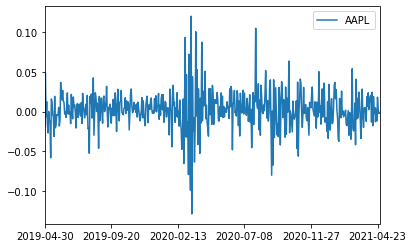

In [17]:
returns[['AAPL']].plot()

In [18]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)

In [19]:
print (returns.shape)

(503, 405)


## 4. Find Candidate Pairs
Given the pricing data, fundamental data, and ESG data, we will first classify stocks into clusters.  Within clusters, we then look for strong mean-reverting pair relationships.

The first hypothesis above is that "Stocks that share loadings to common factors in the past should be related in the future". Common factors are things like sector/industry membership and widely known ranking schemes like momentum and value. We could specify the common factors *a priori* to well known factors, or alternatively, we could let the data speak for itself. We take the latter approach. We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock. For a nice visual introduction to what PCA is doing, take a look [here](http://setosa.io/ev/principal-component-analysis/).

We take these features, add in the fundamental and ESG features, and then use the `DBSCAN` **unsupervised** [clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan) which is available in [`scikit-learn`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). `DBSCAN` has advantages over `KMeans` in this use case, specifically:

- `DBSCAN` does not cluster *all* stocks; it leaves out stocks which do not neatly fit into a cluster.
- As a result, you do not need to specify the number of clusters.

The clustering algorithm will give us sensible *candidate* pairs. We will need to do some validation in the next step.

### 4.a PCA Decomposition and DBSCAN Clustering

In [20]:
N_PRIN_COMPONENTS = 15
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
pca.components_.T.shape

(405, 15)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. Let's add some fundamental and ESG values as well to make the model more robust.

In [22]:
X = np.hstack(
    (pca.components_.T,
     result_esg_df['Market Cap'][returns.columns].values[:, np.newaxis],
     result_esg_df['Controversy Score'][returns.columns].values[:, np.newaxis])
)

print (X.shape)

(405, 17)


In [23]:
X = preprocessing.StandardScaler().fit_transform(X)
print (X.shape)

(405, 17)


In [24]:
# clf = DBSCAN(eps=1.9, min_samples=3)
clf = DBSCAN(eps=1.9, min_samples=5)
print (clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

Clusters discovered: 4


In [25]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print ("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))

Total pairs possible in universe: 81810 


In [26]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [27]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 522


We have reduced the search space for pairs from more than 80,000 to approximately 500.

### 4.b Cluster Visualization
We have found 4 clusters. The data are clustered in 17 dimensions. As an attempt to visualize what has happened in 2d, we can try with [T-SNE](https://distill.pub/2016/misread-tsne/). T-SNE is an algorithm for visualizing very high dimension data in 2d, created in part by Geoff Hinton. We visualize the discovered pairs to help us gain confidence that the `DBSCAN` output is sensible; i.e., we want to see that T-SNE and DBSCAN both find our clusters.

In [28]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

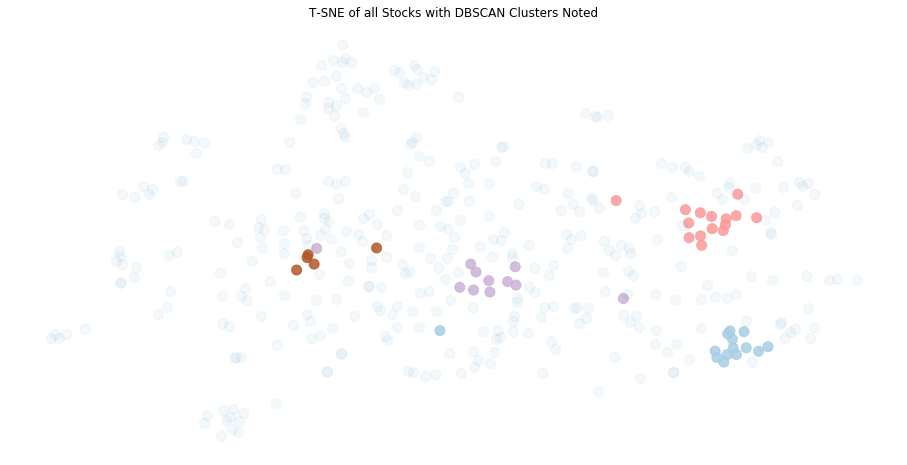

In [29]:
# plt.figure(1, facecolor='white')
plt.figure(figsize=(16, 8), facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

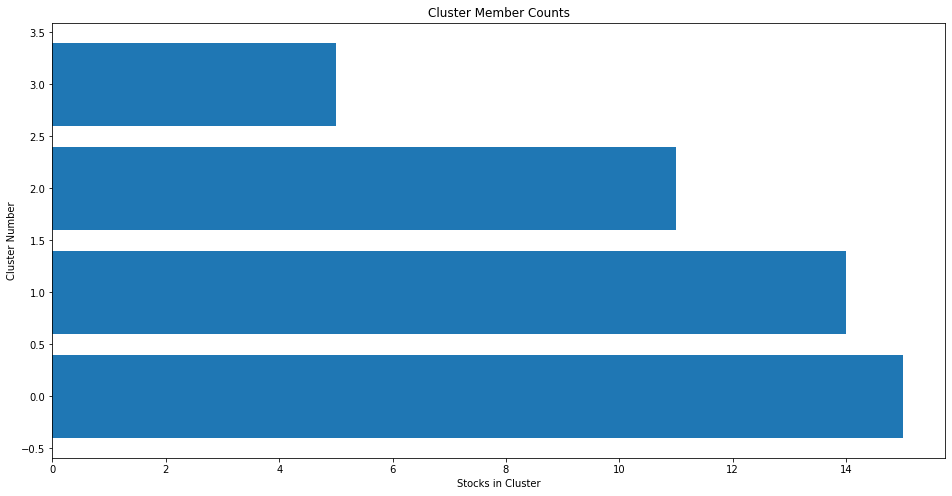

In [30]:
plt.figure(figsize=(16, 8))
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

To again visualize if our clustering is doing anything sensible, let's look at a few clusters.

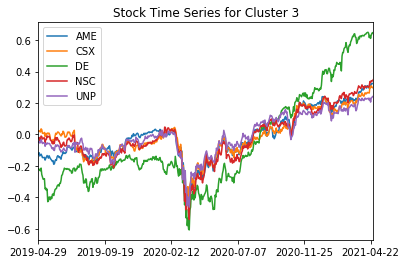

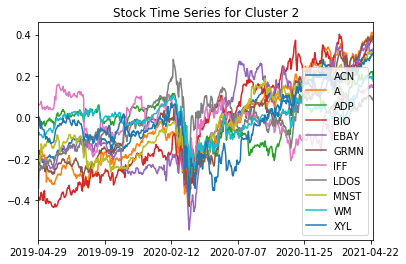

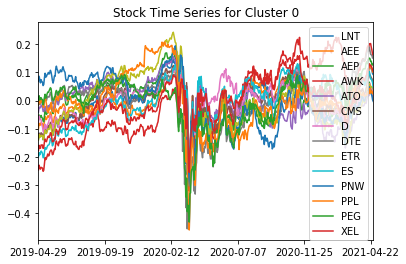

In [31]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(combined_stock_price_df[tickers].mean())
    data = np.log(combined_stock_price_df[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

We might be interested to see how a cluster looks for a particular stock. Large industrial companies share similar regulatory oversight and economic sensitivities. We indeed see that our clustering has found an Industrials stock cluster.

In [40]:
which_cluster = clustered_series.loc['CSX']
clustered_series[clustered_series == which_cluster]

AME    3
CSX    3
DE     3
NSC    3
UNP    3
dtype: int64

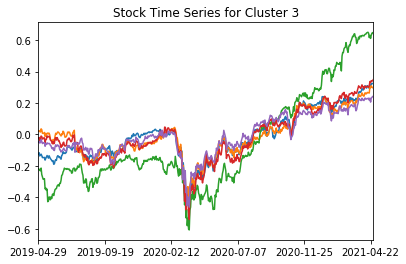

In [33]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(combined_stock_price_df[tickers].mean())
data = np.log(combined_stock_price_df[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster)

Now that we have sensible clusters of common stocks, we can validate the cointegration relationships.

In [34]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [35]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        combined_stock_price_df[tickers].dropna()
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [36]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

Let's view the pairs with a validated cointegration relationship.

In [37]:
pairs

[('MO', 'HSY'),
 ('COST', 'PG'),
 ('COST', 'WMT'),
 ('HSY', 'PM'),
 ('HSY', 'RSG'),
 ('HSY', 'TGT'),
 ('MDLZ', 'PM'),
 ('MDLZ', 'PG'),
 ('MDLZ', 'RSG'),
 ('MDLZ', 'TGT'),
 ('PEP', 'PM'),
 ('PEP', 'PG'),
 ('PEP', 'RSG'),
 ('PEP', 'TGT'),
 ('PEP', 'VZ'),
 ('PEP', 'WMT'),
 ('PFE', 'PM'),
 ('PFE', 'RSG'),
 ('VZ', 'WMT'),
 ('LNT', 'CMS'),
 ('AEP', 'ATO'),
 ('AEP', 'ETR'),
 ('AEP', 'PPL'),
 ('DTE', 'PEG'),
 ('AME', 'UNP'),
 ('CSX', 'DE'),
 ('CSX', 'NSC')]

In [38]:
print ("We found %d pairs." % len(pairs))

We found 27 pairs.


In [39]:
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

In those pairs, there are 25 unique tickers.


### 4.c Pair Visualization
For the pairs we found and validated, let's visualize them in 2d space with T-SNE again.

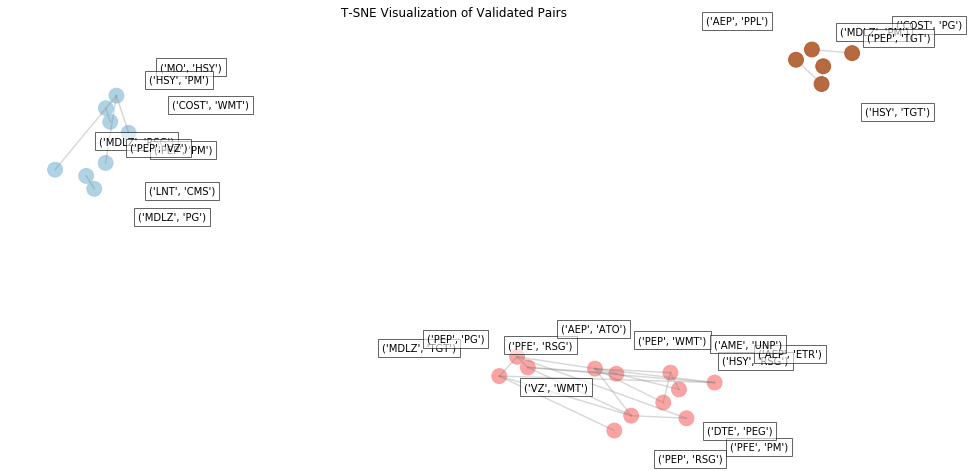

In [41]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

# plt.figure(1, facecolor='white')
plt.figure(figsize=(16, 8), facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray')

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values.ravel(), cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs')


# Add the participant names as text labels for each point
for index, (x_pos, y_pos, label) in enumerate(zip(X_tsne[:, 0], X_tsne[:, 1], pairs)):

    dx = x_pos - X_tsne[:, 0]
    dx[index] = 1
    dy = y_pos - X_tsne[:, 1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x_pos = x_pos + 5
    else:
        horizontalalignment = 'right'
        x_pos = x_pos - 5
    if this_dy > 0:
        verticalalignment = 'bottom'
        y_pos = y_pos + 5
    else:
        verticalalignment = 'top'
        y_pos = y_pos - 5
    
    plt.text(x_pos, y_pos, label, size=10,
         horizontalalignment=horizontalalignment,
         verticalalignment=verticalalignment,
         bbox=dict(facecolor='w',
                   alpha=.6))

# Show the plot
plt.show()

We have found a nice number of pairs to use in a pairs trading strategy.

## 5. Pairs Trading Analysis

### 5.a Historical Stock Prices

To examine how well our identified pairs trade algorithmically, we will first reload the historical stock prices.

In [52]:
stock_data = combined_stock_price_df.dropna()
stock_data

,MMM,ABT,ACN,ATVI,ADBE,AAP,AES,AFL,A,APD,...,WY,WHR,WMB,WLTW,WYNN,XEL,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-29,177.170822,75.875763,176.433182,47.852070,286.140015,165.076157,16.146397,47.306011,76.098206,195.120132,...,24.866016,129.702393,24.468395,176.627579,143.701981,52.583630,81.727402,100.136955,119.042313,100.104774
2019-04-30,176.518814,77.126305,177.854675,47.664215,289.250000,164.630768,16.181368,47.933960,77.249573,197.247955,...,25.185532,129.945801,24.502991,179.371536,139.529129,53.579346,81.317879,100.706123,121.337830,100.678154
2019-05-01,173.314636,76.331390,176.530518,48.010258,283.350006,162.166031,15.973430,47.781731,76.235962,193.759033,...,25.035170,130.825699,24.200274,170.643311,141.161575,53.010361,81.210625,98.342590,119.426537,100.628731
2019-05-02,172.085114,76.370163,174.661133,48.989048,279.640015,165.086060,16.115202,47.810272,76.954338,199.030746,...,24.866016,133.212662,23.750519,173.688934,140.601318,53.029331,77.554253,98.149635,121.387100,101.973213
2019-05-03,172.522873,76.282928,172.314682,46.616219,285.579987,161.611694,16.001785,48.038628,78.026978,200.880646,...,25.166739,133.353088,23.862953,174.924728,142.340012,53.655212,80.235596,99.095055,122.470810,102.566360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-22,200.899994,123.500000,290.160004,93.699997,507.290009,200.300003,28.320000,52.939999,134.529999,284.739990,...,37.830002,233.190002,23.240000,233.149994,124.379997,71.120003,109.080002,117.820000,177.380005,169.070007
2021-04-23,202.199997,123.309998,291.739990,93.019997,515.840027,199.750000,28.299999,53.369999,136.679993,290.299988,...,38.200001,238.940002,23.610001,232.889999,124.150002,71.080002,110.480003,117.720001,177.619995,170.539993
2021-04-26,199.630005,122.580002,289.519989,94.239998,515.700012,197.139999,28.209999,53.369999,137.339996,290.179993,...,38.840000,236.119995,23.969999,231.300003,125.000000,70.599998,110.440002,115.680000,175.720001,169.800003


Since `LNT` (Alliant Energy Corporation) and `CMS` (CMS Energy Corporation) were identified as being a good pairs trading candidate, we define them as `symbol_one` and `symbol_two` in our trading algorithm below:

In [53]:
symbol_one = 'LNT'
symbol_two = 'CMS'

In [54]:
stock_data = stock_data[[symbol_one,symbol_two]]
stock_data.index.name = 'Date'
stock_data

,LNT,CMS
Date,,
2019-04-29,44.020252,51.775612
2019-04-30,44.923862,52.647541
2019-05-01,44.495831,52.107315
2019-05-02,44.400723,52.091099
2019-05-03,44.914356,52.740089
...,...,...
2021-04-22,56.849998,64.510002
2021-04-23,56.439999,64.129997
2021-04-26,56.240002,63.950001


We focus on price data since January 1, 2020 in order to capture the coronavirus sell-off in March 2020 and subsequent stock market recovery.

In [55]:
stock1_name, stock2_name = symbol_one,symbol_two
orig_data = stock_data.loc['2020-01-01':,]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

Let's now plot the historical stock prices for `LNT` and `CMS`.

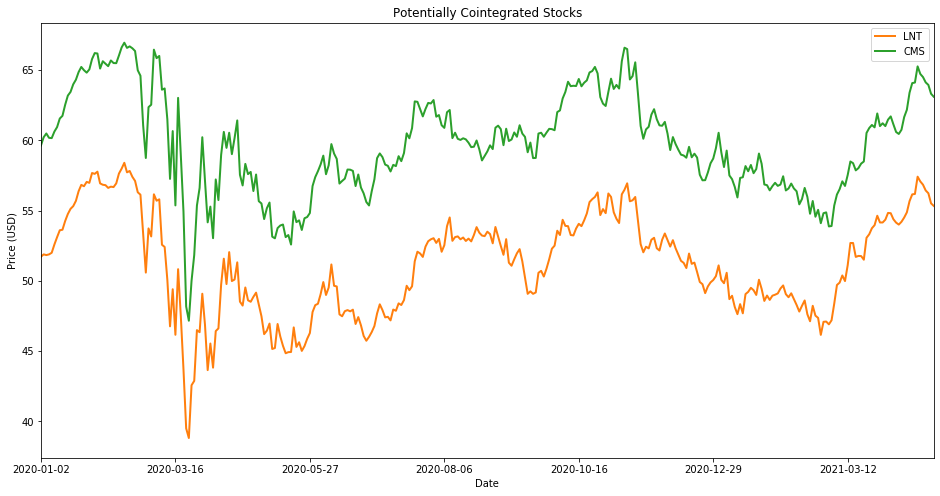

In [56]:
plt.figure(figsize = (16,8))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

These companies do indeed seem to have related price series.

### 5.b Bayesian Modeling

We take a Bayesian approach to pairs trading using probabilistic programming, which is a form of Bayesian machine learning. Unlike simpler frequentist cointegration tests, our Bayesian approach allows us to monitor the relationship between a pair of equities over time, which allows us to follow pairs whose cointegration parameters change steadily or abruptly. When combined with a simple mean-reversion trading algorithm, we demonstrate this to be a viable theoretical trading strategy, ready for further evaluation and risk management.

To learn more about this Bayesian approach to pairs trading, you can read AlphaWave Data's article titled [Bayesian Pairs Trading using Corporate Supply Chain Data](https://medium.com/@hdonnelly6/bayesian-pairs-trading-using-corporate-supply-chain-data-8b96305686d).

We will use a Bayesian probabilistic programming package called [PyMC3](https://docs.pymc.io/). Its simple syntax is excellent for prototyping as seen with the model description in the code below.

In [57]:
with pm.Model() as model:
    
    # inject external stock data
    stock1 = th.shared(data1)
    stock2 = th.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=beta_sigma,
                                 shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y',
                           mu=stock2_regression,
                           sd=sd,
                           observed=stock2)

In [58]:
with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    trace = pm.sample(2000,tune=1000,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, beta_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
The number of effective samples is smaller than 10% for some parameters.


Let's plot the $\beta$ distribution from the model over time.

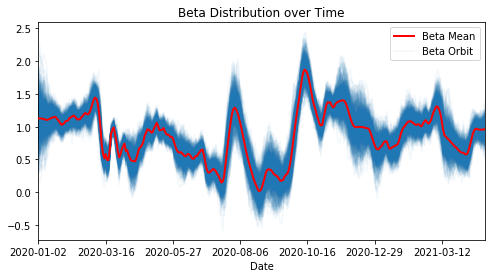

In [59]:
rolling_beta = trace[beta].T.mean(axis=1)

plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)
for orbit in trace[beta][:500]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
plt.legend(['Beta Mean','Beta Orbit'])

plt.show()

Notice that $\beta$ appears to shift between somewhat fixed regimes, and often does so abruptly.

### 5.c Trading Strategy

Knowing that two stocks may or may not be cointegrated does not explicitly define a trading strategy. For that we present the following simple mean-reversion style trading algorithm, which capitalizes on the assumed mean-reverting behavior of a cointegrated portfolio of stocks. We trade whenever our portfolio is moving back toward its mean value. When the algorithm is not trading, we dynamically update $\beta$ and its other parameters, to adapt to potentially changing cointegration conditions. Once a trade begins, we are forced to trade the two stocks at a fixed rate, and so our $\beta$ becomes locked for the duration of the trade. The algorithm's exact implementation is as follows:

1. Define a "signal", which should mean-revert to zero if $\beta$ remains relatively stationary.
2. Define a "smoothed signal", a 15-day moving average of the "signal".
2. If we are not trading...
 * Update $\beta$ so that it does not remain fixed while we aren't trading.
 * If the smoothed signal is above zero _and_ moving downward, short our portfolio.
 * If the smoothed signal is below zero _and_ moving upward, go long on our portfolio.
3. If we are trading long...
 * If the smoothed signal goes below its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal rises through the zero line, we've reached the mean. Close the trade.
4. If we are trading short...
 * If the smoothed signal goes above its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal falls through the zero line, we've reached the mean. Close the trade.

In [60]:
def getStrategyPortfolioWeights(rolling_beta,stock_name1,stock_name2,data,smoothing_window=15):

    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    fixed_beta = rolling_beta[smoothing_window]
    signal = fixed_beta*data1 - data2
    smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0

    leverage = 0*data.copy()
    for i in range(smoothing_window,data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":

            # dynamically rebalance the signal when not trading
            fixed_beta = rolling_beta[i]
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:

                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)

                trading = "short"
                trading_start = smoothed_signal[i]

            elif smoothed_signal[i]<0 and d_smoothed_signal[i]>0:

                fixed_beta = rolling_beta[i]
                leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)

                trading = "long"
                trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0


        elif trading=="long":

            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]>0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":

            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]<0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

### 5.d Backtesting & Performance in Market Drops

As a long-short algorithm, the expectation is that this algorithm would perform well during market drops. The backtest here includes the coronavirus sell-off in March 2020.

In [61]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta,stock1_name, stock2_name,data).fillna(0)

In [62]:
def backtest(pricingDF,leverageDF,start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1,pricing.shape[0]):
        
        if np.any(leverage[t]!=leverage[t-1]):

            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash)/start_cash
    return (
        pd.DataFrame( shares, index=pricingDF.index, columns=pricingDF.columns ),
        pd.Series( cash, index=pricingDF.index ),
        pd.Series( pct_returns, index=pricingDF.index)
    )

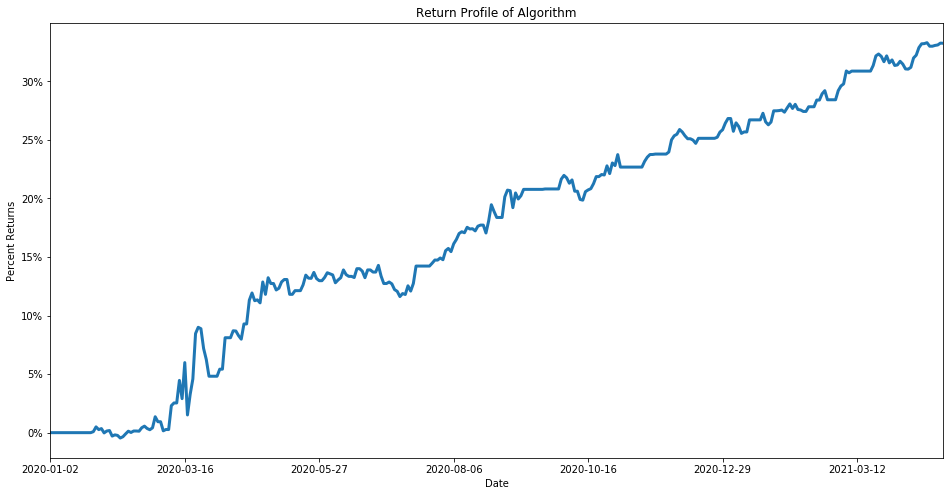

In [64]:
shares, cash, returns = backtest( orig_data, portfolioWeights, 1e6 )

plt.figure(figsize = (16,8))
ax = plt.gca()
plt.title("Return Profile of Algorithm")
plt.ylabel("Percent Returns")
returns.plot(ax=ax,linewidth=3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

As we might have hoped, performance through market drops is strong. Returns are somewhat outsized due to our portfolio only being two stocks. For a finalized version of this algorithm, we might trade a hundred pairs or more to reduce volatility.

## 6. Conclusions & Potential Future Directions

After using PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock, we added the fundamental and ESG features, and then used the `DBSCAN` **unsupervised** [clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan), which is available in [`scikit-learn`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), to identify stock pairs. `DBSCAN`'s advantage is that it leaves out stocks which do not neatly fit into a cluster. As a result, you do not need to specify the number of clusters when using `DBSCAN`.

We also demonstrated a robust prototype for what would be built into a more sophisticated pairs trading algorithm. There are many places where this algorithm and approach could be improved, including expanding the portfolio, creating criteria for when $\beta$ is suitable to trade over, backtesting over more periods, using a Bayesian model with fewer simplifying assumptions, and investigating potential nonlinear relationships between stocks.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by AlphaWave Data, Inc. ("AlphaWave Data"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, AlphaWave Data, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to AlphaWave Data, Inc. at the time of publication. AlphaWave Data makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*